In [1]:
!pip uninstall tensorflow tensorflow_gpu protobuf --yes

Uninstalling tensorflow-1.4.0:
  Successfully uninstalled tensorflow-1.4.0
Cannot uninstall requirement tensorflow-gpu, not installed
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install protobuf==3.6.0 tensorflow==1.8.0 tensorflow_gpu==1.8.0 --no-cache-dir

    100% |████████████████████████████████| 7.1MB 27.8MB/s ta 0:00:01    30% |█████████▋                      | 2.2MB 10.2MB/s eta 0:00:01
    100% |████████████████████████████████| 49.1MB 78.3MB/s ta 0:00:01    26% |████████▋                       | 13.2MB 81.8MB/s eta 0:00:01
    100% |████████████████████████████████| 216.3MB 46.9MB/s ta 0:00:01  6% |██                              | 14.2MB 66.0MB/s eta 0:00:04    21% |██████▉                         | 46.1MB 76.4MB/s eta 0:00:03    48% |███████████████▍                | 104.0MB 63.9MB/s eta 0:00:02    76% |████████████████████████▋       | 166.4MB 33.3MB/s eta 0:00:02
    100% |████████████████████████████████| 92kB 41.1MB/s ta 0:00:01
    100% |████████████████████████████████| 3.1MB 46.0MB/s ta 0:00:01
    100% |████████████████████████████████| 9.3MB 46.7MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 49.9MB/s ta 0:00:01
  Found existing installation: protobuf 3.4.1
    Uninstalling protobuf-3.4.1:
      Succe

In [3]:
import os
import scipy
import os.path
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.linalg as la
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn
bidynrnn = tf.nn.bidirectional_dynamic_rnn

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log(1 + np.exp(x)) + 1e-5

np.random.seed(100) #4, 100
H = 140
A = 0.8 * np.random.randn(H, H)
R = la.expm(A - A.T)
B = 2 * np.random.randn(1, H)
b = 0.5 * np.random.randn(H, 1)
c = 0.5 * np.random.randn(H, 1)
bias_h = np.random.rand(1, H)
d = 0.05 * np.random.randn(H, 1)

np.random.seed(0)
T = 300; N = 10000; training_size = 9000
sigma_c = 5.3
h = np.zeros((N, T + 1, H))
h[:, 0, :] = norm.rvs(mean=None, cov=np.eye(H), size=N)
y = np.zeros((N, T + 1, 1))

for i in range(1, T + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i - 1, :], R) + np.tanh(np.dot(y[:, i - 1], B))) + 0.7 * h[:, i - 1, :] + bias_h
    y[:, i] = (1.5 * np.dot(h[:, i, :], b) + 1 * np.tanh(np.dot(h[:, i, :], c))
               + 1 * softplus(np.tanh(np.dot(h[:, i, :], d)) - 10) * np.random.randn(N, 1))

y = y[:, 1:]
y = y - np.mean(y)
y_tilde = (y + sigma_c * np.random.randn(N, T, 1))

In [5]:
seq_length = 150
offset = 50
training_data = y_tilde[:training_size, offset:offset+seq_length]
testing_data = y_tilde[training_size:, offset:offset+seq_length]

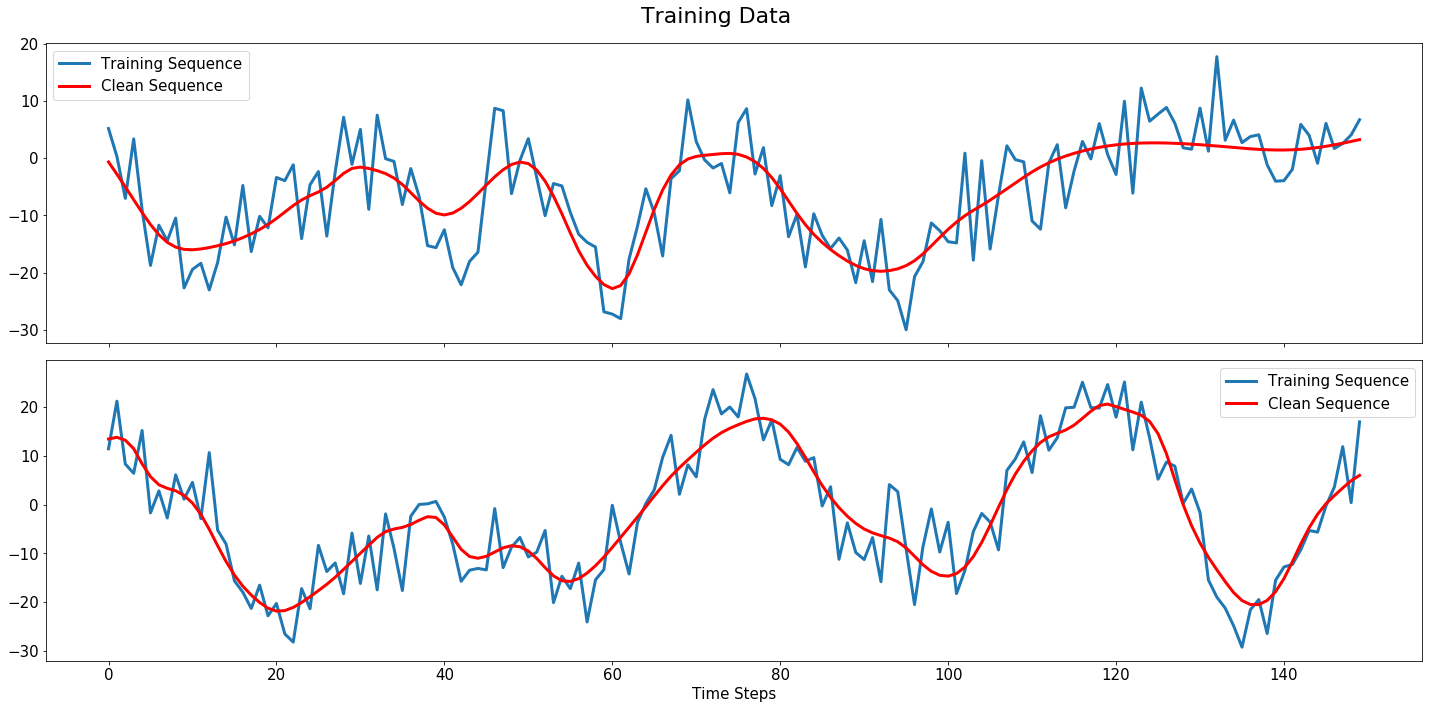

In [6]:
idx = np.random.randint(0, N, 2)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
ax1.plot(y_tilde[idx[0], offset:offset+seq_length], label='Training Sequence', linewidth=3.0)
ax1.plot(y[idx[0], offset:offset+seq_length], 'r', label='Clean Sequence', linewidth=3.0)
ax2.plot(y_tilde[idx[1], offset:offset+seq_length], label='Training Sequence', linewidth=3.0)
ax2.plot(y[idx[1], offset:offset+seq_length], 'r', label='Clean Sequence', linewidth=3.0)
ax2.set_xlabel('Time Steps', fontsize=15)
for ax in (ax1, ax2):
    ax.legend(fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15);
plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig.suptitle('Training Data', fontsize=22)
# plt.savefig(path + '/training_data.pdf', bbox_inches='tight')
plt.show()

In [6]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [7]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, reg_lambda=0., reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._regulariser = tf.contrib.layers.l2_regularizer(scale=reg_lambda)
        self._layer_mu = tf.layers.Dense(self._event_size, kernel_regularizer=self._regulariser)
        self._layer_sigma = tf.layers.Dense(self._event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = self._layer_mu(hidden)
        std = self._layer_sigma(hidden)
        return (mean, std), state
        
class SamplingCell(tf.contrib.rnn.RNNCell):

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.MultivariateNormalDiag(mean, std).sample()
        return (mean, std, sample), (state, sample)

In [19]:
class RegularisedRobustARGenerator(object):
    """
    Model to test
    """

    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size, dim_z=20, future_steps=30, 
                 forward_initialiser=0., w_lambda=0.):
        self._data = data                                               # B x T x D
        self._B = batch_size                                            # B - batch size
        self._T = seq_length                                            # T - number of time steps
        self._D = 1                                                     # D - dimensionality of each time step
        self._H = n_hidden                                              # H - dimensionality of RNN hidden states
        self._Z = dim_z
        self._Sz = n_samples                                            # Sz - number of samples from the posterior
        self._Sz_forw = n_samples
        self._K = future_steps                                          # K - number of future steps for prediction
        self._w_lambda = w_lambda
        self._forward_initialiser = forward_initialiser
        
        self.initialise_variables                                       #
        
        self.q_z = self.make_posterior_z
        self.p_y = self.make_transitional
        self.make_reconstruction
        self.compute_elbo
        
        self.optimise
        
#         self.q_psi_z_temp = self.make_posterior_forward_z_temp
        self.q_psi_z = self.make_posterior_forward_z
        self.p_y_bar = self.make_rnn_forward
        self.make_reconstruction_forward
        self.compute_elbo_forward
        
#         self.optimise_forward
        self.E_step_forward
        self.M_step_forward

    @define_scope
    def initialise_variables(self):
        # Initialises all variables and RNN cells
        self._cell = tfn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, self._D, reg_lambda=self._w_lambda)
        self._sampling_cell = SamplingCell(self._gauss_cell, self._D)
        
        self._post_cell_z = tfn.GRUBlockCell(self._H)
        self._layer_z = tf.layers.Dense(self._H, tf.nn.relu)
        
        self._forward_post_cell_z = tfn.GRUBlockCell(self._H)
        
        self._most_likely_pred = tf.get_variable(shape=(1, self._K, self._D), name='best_forward_sequence',
                                                 initializer=tf.constant_initializer(self._forward_initialiser))
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self._optimiser_forward = tf.train.AdamOptimizer(0.001)
    
    @define_scope
    def make_posterior_z(self):
        _, h = dynrnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, stds)
        return posterior_z

    @define_scope
    def make_kl_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))

    @define_scope
    def make_transitional(self):
        self._code_z = self.q_z.sample(self._Sz)
        hidden = self._layer_z(tf.reshape(self._code_z, [-1, self._Z]))
        state_and_sample = (hidden, tf.zeros((self._B * self._Sz, self._D)))
        inputs = tf.zeros((self._B * self._Sz, self._T, self._D))
        (means, stds, self._code_y), _ = dynrnn(self._sampling_cell, inputs, initial_state=state_and_sample)
        return tfd.MultivariateNormalDiag(means, stds)

    @define_scope
    def make_reconstruction(self):
        data = tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1))
        data = tf.reshape(data, [-1, self._T, self._D])
        self._gen_std = tf.nn.softplus(tf.get_variable(shape=(), name='gen_std', 
                                       initializer=tf.constant_initializer(1))) + 1e-5
        
        gen_prob = tfd.MultivariateNormalDiag(self._code_y, scale_identity_multiplier=self._gen_std)
        return tf.reduce_sum(gen_prob.log_prob(data)) / self._Sz

    @define_scope
    def compute_elbo(self):
        kl_z = self.make_kl_z
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z
        return loss, kl_z, reconstruction
    
    @define_scope
    def optimise(self):
        # Optimses the ELBO function
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
#     @define_scope
#     def E_step(self):
#         # Optimses the ELBO function
#         vars_e = [v for v in tf.trainable_variables() if 'make_posterior' in v.name]
#         gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0], var_list=vars_e))
#         gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
#         return self._optimiser.apply_gradients(zip(gradients, variables))
    
#     @define_scope
#     def M_step(self):
#         # Optimses the ELBO function
#         vars_m = [v for v in tf.trainable_variables() if 'make_posterior' not in v.name]
#         gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0], var_list=vars_m))
#         gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
#         return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def make_generative_forward(self):
        return tfd.MultivariateNormalDiag(self._most_likely_pred, scale_identity_multiplier=self._gen_std)   
    
    @define_scope
    def make_posterior_forward_z(self):
        inputs = tf.concat([tf.tile(self._data[:1], (self._Sz_forw, 1, 1)), 
                            self.make_generative_forward.sample(self._Sz_forw)[:, 0]], 1)
        _, h = dynrnn(self._forward_post_cell_z, inputs, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, stds)
        return posterior_z
    
    @define_scope
    def make_kl_forward_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_psi_z, p))
    
#     @define_scope
#     def make_posterior_forward_z_temp(self):
#         _, h = dynrnn(self._forward_post_cell_z, self._data[:1], dtype=tf.float32)
#         means = tf.layers.dense(h, self._Z)
#         stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
#         posterior_z = tfd.MultivariateNormalDiag(means, stds)
#         return posterior_z
    
#     @define_scope
#     def compute_elbo_forward_temp(self):
#         p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
#         kl_z =  tf.reduce_sum(tfd.kl_divergence(self.q_psi_z_temp, p))
        
#         code_z_forw = self.q_psi_z_temp.sample(self._Sz_forw)
#         code_z_forw = tf.reshape(code_z_forw, [-1, self._Z])
#         fake_inputs = tf.zeros((self._Sz_forw, self._T, self._D))
#         state_and_sample = (self._layer_z(code_z_forw), tf.zeros((self._Sz_forw, self._D)))
#         (_, _, self._code_y_forw_temp), (_, _) = dynrnn(self._sampling_cell, inputs=fake_inputs, 
#                                                         initial_state=state_and_sample)
        
#         p_x = tfd.MultivariateNormalDiag(self._code_y_forw_temp, scale_identity_multiplier=self._gen_std)
#         data = tf.tile(self._data[:1], (self._Sz_forw, 1, 1))
#         reconstruction_x = tf.reduce_sum(p_x.log_prob(data)) / self._Sz_forw
        
#         return reconstruction_x - kl_z
        
        
    @define_scope
    def make_rnn_forward(self):
        self._code_z_forw = self.q_psi_z.sample()
#         fake_inputs = tf.zeros((self._Sz, self._T + self._K, self._D))
        fake_inputs = tf.zeros((self._Sz_forw, self._T, self._D))
        state_and_sample = (self._layer_z(self._code_z_forw), tf.zeros((self._Sz_forw, self._D)))
        (means, stds, code_y_forw), (hT, sample) = dynrnn(self._sampling_cell, inputs=fake_inputs, 
                                                         initial_state=state_and_sample)
        
#         inputs = tf.concat([code_y_forw[:, -1:], 
#                             tf.tile(self._most_likely_pred[:, :-1], (self._Sz_forw, 1, 1))], 1)
#         (means_ybar, stds_ybar), _ = dynrnn(self._gauss_cell, inputs=inputs, initial_state=hT)
        
        fake_inputs = tf.zeros((self._Sz_forw, self._K, self._D))
        (means_ybar, stds_ybar, _), _ = dynrnn(self._sampling_cell, inputs=fake_inputs, 
                                               initial_state=(hT, sample))
        means_ybar = means[:, -self._K:]
        stds_ybar = stds[:, -self._K:]
        self._code_y_forw = code_y_forw[:, :self._T]
        p_y_bar = tfd.MultivariateNormalDiag(means_ybar, stds_ybar)
        return p_y_bar
    
    @define_scope
    def make_reconstruction_forward(self):
        forward = tf.tile(self._most_likely_pred, [self._Sz_forw, 1, 1])
        exp_py = tf.reduce_sum(self.p_y_bar.log_prob(forward)) / self._Sz_forw
        
        p_x = tfd.MultivariateNormalDiag(self._code_y_forw, scale_identity_multiplier=self._gen_std)
        data = tf.tile(self._data[:1], (self._Sz_forw, 1, 1))
        exp_px = tf.reduce_sum(p_x.log_prob(data)) / self._Sz_forw
        return exp_px, exp_py
    
    @define_scope
    def compute_elbo_forward(self):
        kl_z = self.make_kl_forward_z
        rec_x, rec_y = self.make_reconstruction_forward
        return rec_y + rec_x - kl_z, rec_x, rec_y, kl_z
    
#     @define_scope
#     def optimise_forward(self):
#         var_forw = [v for v in tf.trainable_variables() if 'posterior' in v.name]
#         gradients, variables = zip(*self._optimiser_forward.compute_gradients(-self.compute_elbo_forward_temp,
#                                                                               var_list=var_forw))
#         gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
#         return self._optimiser_forward.apply_gradients(zip(gradients, variables))

    @define_scope
    def E_step_forward(self):
        var_e = [v for v in tf.trainable_variables() if 'posterior' in v.name]
        gradients, variables = zip(*self._optimiser_forward.compute_gradients(-self.compute_elbo_forward[0], 
                                                                              var_list=var_e))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser_forward.apply_gradients(zip(gradients, variables))

    @define_scope
    def M_step_forward(self):
        var_m = [v for v in tf.trainable_variables() if 'best_forward_sequence' in v.name]
        gradients, variables = zip(*self._optimiser_forward.compute_gradients(-self.compute_elbo_forward[0], 
                                                                              var_list=var_m))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser_forward.apply_gradients(zip(gradients, variables))

In [10]:
np.random.seed(0)
idx = np.random.randint(0, testing_data.shape[0], 50)
test_batch = testing_data[idx, :T]
forw_idx = 3
last_observed = test_batch[forw_idx:forw_idx+1, -1, 0]

In [20]:
tf.reset_default_graph()
S = 30
B = 50 
T = 100 
I = 20000
H = 50
K = 30
Z = 20
w_lambda = 0.
model_name = model_name = 'H_{}_Z_{}_B_{}_T_{}_K_{}'.format(H, Z, B, T, 30)
path = './bottleneck_model_{}'.format(model_name)
train = False
print_every = 1000
plot = True
restore = True
restore_forward = False
predict = True

os.makedirs(path, exist_ok=True)
os.makedirs(path + '/ckpt', exist_ok=True)
os.makedirs(path + '/training_curves', exist_ok=True)

x_ = tf.placeholder(tf.float32, [None, T, 1])
gen_model = RegularisedRobustARGenerator(x_, n_hidden=H, n_samples=S, seq_length=T, batch_size=B, future_steps=K,
                                         dim_z=Z, forward_initialiser=last_observed)

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])
forw_saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' in v.name])

if restore:
    try:
        saver.restore(sess, path + '/ckpt/modelling.ckpt')
        sess.run(tf.variables_initializer([v for v in tf.global_variables() if 'forward' in v.name]))
        
    except tf.errors.NotFoundError as e:
        print(e)
        print('No model to load!')
        sess.run(tf.global_variables_initializer())
    
    try:
        elbos = np.load(os.path.join(path + '/training_curves/elbos.npy')).tolist()
        llks = np.load(os.path.join(path + '/training_curves/llks.npy')).tolist()
        kls_z = np.load(os.path.join(path + '/training_curves/kls_z.npy')).tolist()
        test_elbos = np.load(os.path.join(path + '/training_curves/test_elbos.npy')).tolist()
    
    except FileNotFoundError as e:
        print('No training curves to restore')
        
else:
    sess.run(tf.global_variables_initializer())
    
if train:
    elbos = []; kls_z = []; llks = []; test_elbos = []
    
    try:
        for i in range(I):
            idx = np.random.randint(0, training_size, B)
            batch = training_data[idx, :T]

            elbo, kl_z, llk = sess.run(gen_model.compute_elbo, {x_: batch})
            elbos.append(elbo); kls_z.append(kl_z); llks.append(llk)

            if i % 100 == 0:
                test_idx = np.random.randint(0, testing_data.shape[0], B)
                test_batch = testing_data[test_idx, :T]
                test_elbo, _, _ = sess.run(gen_model.compute_elbo, {x_: test_batch})
                test_elbos.append(test_elbo)

            if i % print_every == 0:
                print('Iteration:', i, 'ELBO:', elbo, 'KL (z):', kl_z, 'Reconstruction:', llk, 
                      'Test ELBO:', test_elbo)
                saver.save(sess, path + '/ckpt/modelling.ckpt')
                np.save(os.path.join(path + '/training_curves/elbos.npy'), np.stack(elbos))
                np.save(os.path.join(path + '/training_curves/llks.npy'), np.stack(llks))
                np.save(os.path.join(path + '/training_curves/kls_z.npy'), np.stack(kls_z))
                np.save(os.path.join(path + '/training_curves/test_elbos.npy'), np.stack(test_elbos))
            
            sess.run(gen_model.optimise, {x_: batch})
    
    except KeyboardInterrupt as e:
        pass
            
    saver.save(sess, path + '/ckpt/modelling.ckpt')
    np.save(os.path.join(path + '/training_curves/elbos.npy'), np.stack(elbos))
    np.save(os.path.join(path + '/training_curves/llks.npy'), np.stack(llks))
    np.save(os.path.join(path + '/training_curves/kls_z.npy'), np.stack(kls_z))
    np.save(os.path.join(path + '/training_curves/test_elbos.npy'), np.stack(test_elbos))

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./bottleneck_model_H_50_Z_20_B_50_T_100_K_30/ckpt/modelling.ckpt


In [ ]:
# if True:
    fig, ax = plt.subplots(1, 1, figsize=(8,6))    
    plt.plot(kls_z, label='KL', linewidth=3.0)
    plt.plot(llks, 'orange', label='Reconstruction', linewidth=3.0)
    plt.plot(elbos, 'b', label='ELBO', linewidth=3.0)
    plt.plot([100 * i for i in range(len(test_elbos))], test_elbos, 'r', label='Test ELBO', linewidth=3.0)
    ax.set_xlabel('Training Iterations', fontsize=22)
    plt.grid("on")
#     plt.ylim([-70000, 4000])
    plt.legend(fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(top=0.91)
    fig.suptitle('Training (Robust Seq-VAE)', fontsize=26)
    ax.set_xticks([i for i in range(0, 20001, 5000)])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(22);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(22);
#     plt.savefig(path + '/training_curve_robust_new.pdf', bbox_inches='tight')
    plt.show()

In [23]:
prior_means = sess.run(gen_model.p_y.mean(), {x_: test_batch})
latents = sess.run(gen_model._code_y, {x_: test_batch})

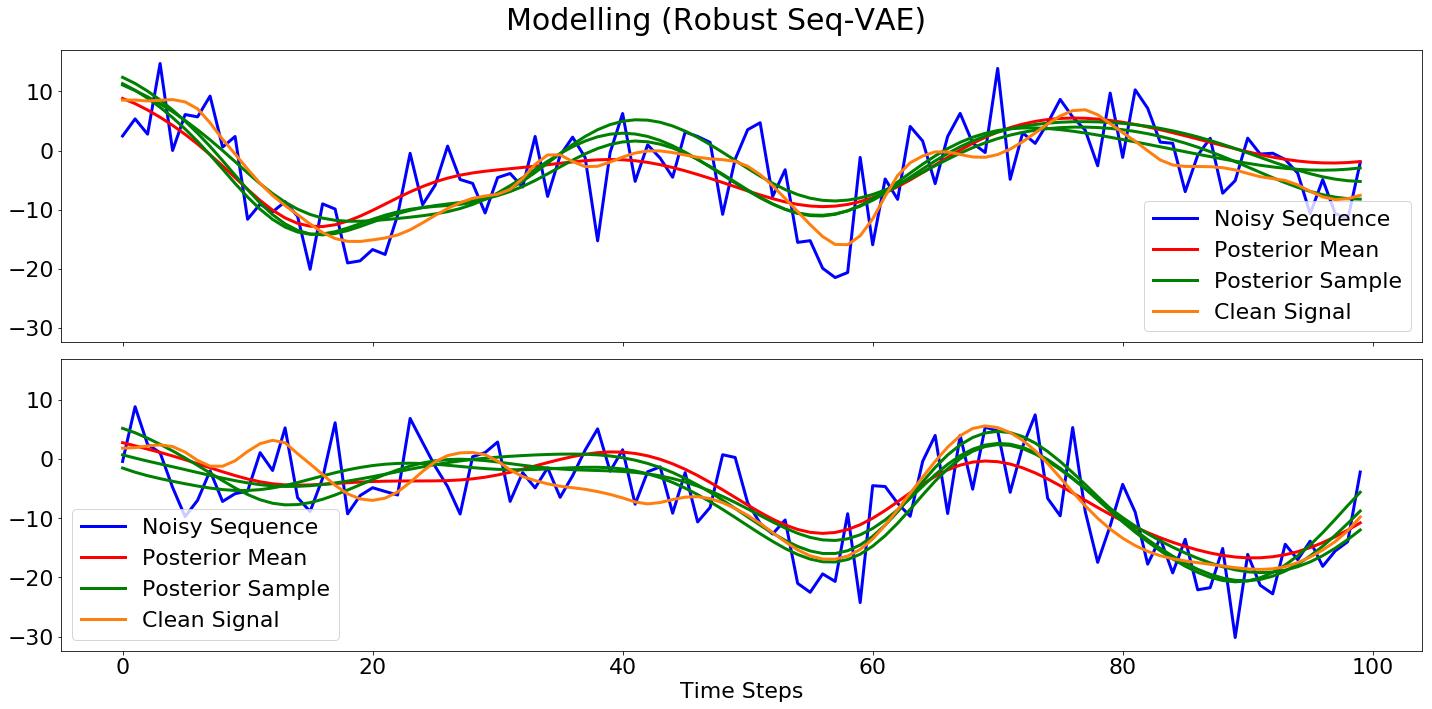

In [138]:
if True:
    plot_idx = np.random.choice(B, 2, replace=False)
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20,10))

    for e, ax in enumerate(axs.flatten()):
        ax.plot(test_batch[plot_idx[e], :], 'b', label='Noisy Sequence', linewidth=3.0)
        ax.plot(np.reshape(prior_means, (S, B, T))[0, plot_idx[e]], 'r', label='Posterior Mean', linewidth=3.0)
        ax.plot(np.reshape(latents, (S, B, T))[0, plot_idx[e]] , 'g', label='Posterior Sample', linewidth=3.0)
        ax.plot(np.reshape(latents, (S, B, T))[1, plot_idx[e]] , 'g', linewidth=3.0)
        ax.plot(np.reshape(latents, (S, B, T))[2, plot_idx[e]] , 'g', linewidth=3.0)
        ax.plot([], [])
        ax.plot(y[training_size:][idx[plot_idx[e]], offset:T+offset], label='Clean Signal', linewidth=3.0)
        ax.legend(fontsize=22)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(22);
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(22);
    axs[-1].set_xlabel('Time Steps', fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    fig.suptitle('Modelling (Robust Seq-VAE)', fontsize=30)
#     plt.savefig(path + '/modelling.pdf', bbox_inches='tight')
    plt.show()

In [109]:
sess.run(gen_model._gen_std)

5.7548265

In [120]:
tf.trainable_variables()

[<tf.Variable 'initialise_variables/best_forward_sequence:0' shape=(1, 30, 1) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/rnn/gru_cell/w_ru:0' shape=(51, 100) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/rnn/gru_cell/b_ru:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/rnn/gru_cell/w_c:0' shape=(51, 50) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/rnn/gru_cell/b_c:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/dense/kernel:0' shape=(50, 20) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/dense/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/dense_1/kernel:0' shape=(50, 20) dtype=float32_ref>,
 <tf.Variable 'make_posterior_z/dense_1/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'make_transitional/dense/kernel:0' shape=(20, 50) dtype=float32_ref>,
 <tf.Variable 'make_transitional/dense/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'make_transitional/rnn/sampling_cell/gaussian_cell/gr

In [130]:
vs = tf.trainable_variables()
weights_a = [v for v in vs if '/make_posterior_z/' in v.name]
weights_b = [v for v in vs if '/make_posterior_forward_z/' in v.name]
copy_op = tf.group(*[tf.assign(b, a) for a, b in zip(weights_a, weights_b)])
sess.run(copy_op)

In [13]:
restore_forward = True
predict = False

In [14]:
forw_idx = 3
if restore_forward:
    try:
        forw_saver.restore(sess, path + '/ckpt/prediction_{}_prova_2.ckpt'.format(forw_idx))        
    except tf.errors.NotFoundError:
        print('No forward prediction variables to load!')
    
    try:
        elbos_forward = np.load(os.path.join(path + '/training_curves/elbos_forward.npy')).tolist()
        llks_x_forward = np.load(os.path.join(path + '/training_curves/llks_x_forward.npy')).tolist()
        llks_y_forward = np.load(os.path.join(path + '/training_curves/llks_y_forward.npy')).tolist()
        kls_z_forward = np.load(os.path.join(path + '/training_curves/kls_z_forward.npy')).tolist()
        
    except FileNotFoundError as e:
        print('No forward prediction training curves to restore')
        elbos_forward = []
        llks_x_forward = []
        llks_y_forward = []
        kls_z_forward = []

else:
    elbos_forward = []
    llks_x_forward = []
    llks_y_forward = []
    kls_z_forward = []
    
if predict:
    try:
        for i in range(3000):
            elbo_f, llk_x_f, llk_y_f, kl_z_f = sess.run(gen_model.compute_elbo_forward, 
                                                        {x_: test_batch[forw_idx:forw_idx+1]})

            elbos_forward.append(elbo_f)
            llks_x_forward.append(llk_x_f)
            llks_y_forward.append(llk_y_f)
            kls_z_forward.append(kl_z_f)

            if i % 1000 == 0:
                print('Iteration:', i, 'ELBO Forward:', elbo_f)

            if i == 0:
                for _ in range(10000):
                    sess.run(gen_model.optimise_forward, {x_: test_batch[forw_idx:forw_idx+1]})        
            if i == 1:
                for _ in range(10000):
                    sess.run(gen_model.M_step_forward, {x_: test_batch[forw_idx:forw_idx+1]})
            else:
                for _ in range(10):
                    sess.run(gen_model.M_step_forward, {x_: test_batch[forw_idx:forw_idx+1]})
            if i > 0:
                for _ in range(10):
                    sess.run(gen_model.E_step_forward, {x_: test_batch[forw_idx:forw_idx+1]})

            if i % 500 == 0:
                forw_saver.save(sess, path + '/ckpt/prediction_{}_prova_2.ckpt'.format(forw_idx))
                np.save(os.path.join(path + '/training_curves/elbos_forward.npy'), np.stack(elbos_forward))
                np.save(os.path.join(path + '/training_curves/llks_x_forward.npy'), np.stack(llks_x_forward))
                np.save(os.path.join(path + '/training_curves/llks_y_forward.npy'), np.stack(llks_y_forward))
                np.save(os.path.join(path + '/training_curves/kls_z_forward.npy'), np.stack(kls_z_forward))

        forw_saver.save(sess, path + '/ckpt/prediction_{}_prova_2.ckpt'.format(forw_idx))
        np.save(os.path.join(path + '/training_curves/elbos_forward.npy'), np.stack(elbos_forward))
        np.save(os.path.join(path + '/training_curves/llks_x_forward.npy'), np.stack(llks_x_forward))
        np.save(os.path.join(path + '/training_curves/llks_y_forward.npy'), np.stack(llks_y_forward))
        np.save(os.path.join(path + '/training_curves/kls_z_forward.npy'), np.stack(kls_z_forward))
        
    except KeyboardInterrupt:
        forw_saver.save(sess, path + '/ckpt/prediction_{}_prova_2.ckpt'.format(forw_idx))
        np.save(os.path.join(path + '/training_curves/elbos_forward.npy'), np.stack(elbos_forward))
        np.save(os.path.join(path + '/training_curves/llks_x_forward.npy'), np.stack(llks_x_forward))
        np.save(os.path.join(path + '/training_curves/llks_y_forward.npy'), np.stack(llks_y_forward))
        np.save(os.path.join(path + '/training_curves/kls_z_forward.npy'), np.stack(kls_z_forward))

INFO:tensorflow:Restoring parameters from ./bottleneck_model_H_50_Z_20_B_50_T_100_K_30/ckpt/prediction_3_prova_2.ckpt


In [ ]:
if True:
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
#     plt.plot(elbos_forward, 'b', label='ELBO', linewidth=3.0)
#     plt.plot(llks_x_forward, 'orange', label='Reconstruction (x)', linewidth=3.0)
    plt.plot(llks_y_forward, label='Reconstruction (y)', linewidth=3.0)
#     plt.plot(kls_z_forward, label='KL (z)', linewidth=3.0)
    ax.set_xlabel('Forward Prediction Iterations', fontsize=15)
    plt.grid("on")
    plt.ylim([-10000000, 10000])
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    fig.suptitle('Forward Prediction (Robust Seq-VAE)', fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15);
#     plt.savefig(path + '/prediction_curve_{}.pdf'.format(forw_idx), bbox_inches='tight')
    plt.show()

In [ ]:
i = 3
latents = sess.run(gen_model._code_y_forw, {x_: test_batch[i:i+1]})
continuation2 = sess.run(gen_model._most_likely_pred, {x_: test_batch[i:i+1]})

if True:
    fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(20,6))
    ax1.plot(test_batch[i, :], 'b', label='Noisy Sequence', linewidth=3.0)
    ax1.plot(np.reshape(latents, (S, 1, T))[1, 0] , 'g', label='Posterior Sample', linewidth=3.0)
    ax1.plot(np.reshape(latents, (S, 1, T))[0, 0] , 'g', linewidth=3.0)
    ax1.plot(np.reshape(latents, (S, 1, T))[2, 0] , 'g', linewidth=3.0)
    ax1.plot(np.concatenate([prior_means[forw_idx], continuation2[0]], 0), label='Best Forward Prediction', 
             linewidth=3.0)
    ax1.plot(prior_means[i], 'r', label='Posterior Means', linewidth=3.0)
    ax1.plot(y[training_size:][idx[i], offset:offset+T+K], label='Clean Signal', linewidth=3.0)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(22);
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(22);
    ax.legend(fontsize=22, loc='lower left')
    plt.xlabel('Time Steps', fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Prediction (Robust Seq-VAE)", fontsize=30)
#     plt.savefig(path + '/prediction_both.pdf'.format(i), bbox_inches='tight')
    plt.show()

In [24]:
j = 3

INFO:tensorflow:Restoring parameters from ./bottleneck_model_H_50_Z_20_B_50_T_100_K_30/ckpt/prediction_2.ckpt


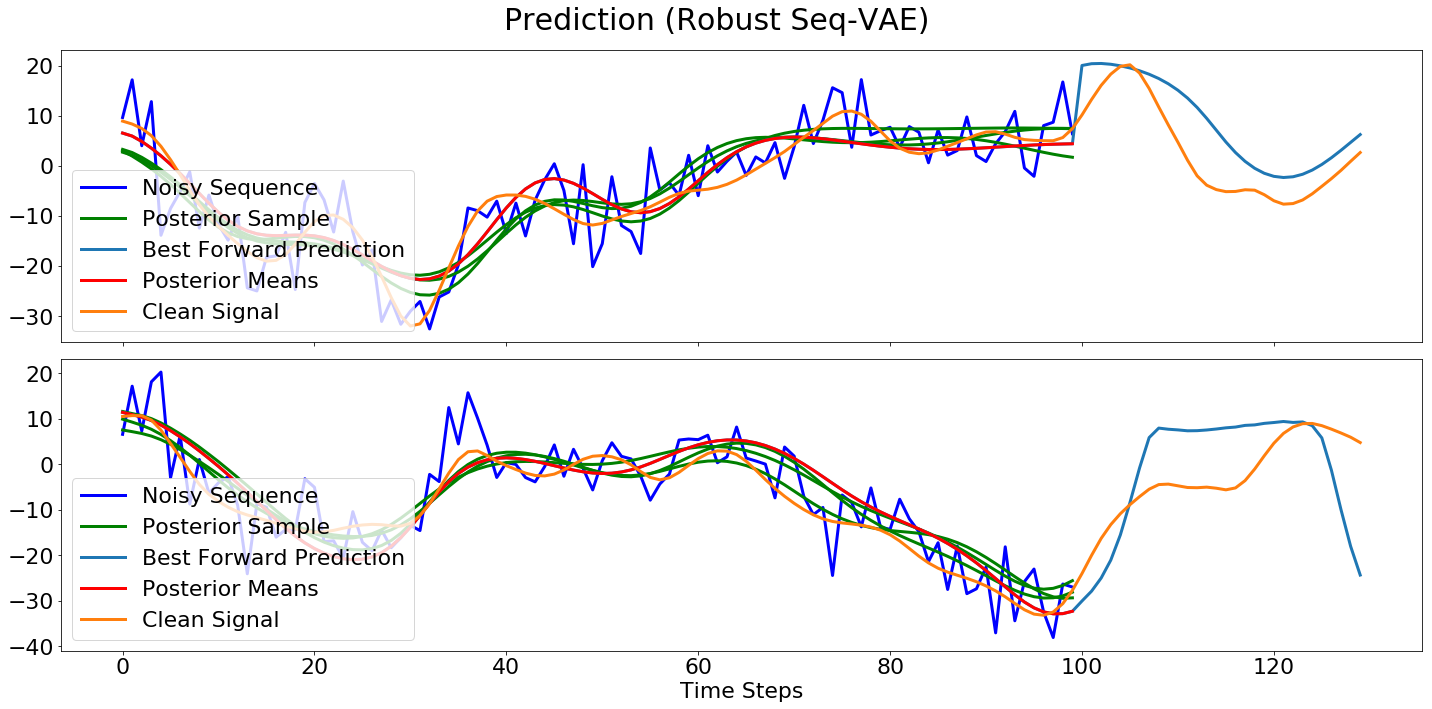

In [27]:
i = 2
forw_saver.restore(sess, path + '/ckpt/prediction_{}.ckpt'.format(i))
continuation1 = sess.run(gen_model._most_likely_pred, {x_: test_batch[i:i+1]})

# j = 3
# forw_saver.restore(sess, path + '/ckpt/prediction_{}.ckpt'.format(j))
# continuation2 = sess.run(gen_model._most_likely_pred, {x_: test_batch[j:j+1]})

if True:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))
    ax1.plot(test_batch[i, :], 'b', label='Noisy Sequence', linewidth=3.0)
    ax1.plot(np.reshape(latents, (S, B, T))[1, i] , 'g', label='Posterior Sample', linewidth=3.0)
    ax1.plot(np.reshape(latents, (S, B, T))[0, i] , 'g', linewidth=3.0)
    ax1.plot(np.reshape(latents, (S, B, T))[2, i] , 'g', linewidth=3.0)
    ax1.plot(np.concatenate([prior_means[i], continuation1[0]], 0), label='Best Forward Prediction', 
             linewidth=3.0)
    ax1.plot(prior_means[i], 'r', label='Posterior Means', linewidth=3.0)
    ax1.plot(y[training_size:][idx[i], offset:offset+T+30], label='Clean Signal', linewidth=3.0)
    
    ax2.plot(test_batch[j, :], 'b', label='Noisy Sequence', linewidth=3.0)
    ax2.plot(np.reshape(latents, (S, B, T))[1, j] , 'g', label='Posterior Sample', linewidth=3.0)
    ax2.plot(np.reshape(latents, (S, B, T))[0, j] , 'g', linewidth=3.0)
    ax2.plot(np.reshape(latents, (S, B, T))[2, j] , 'g', linewidth=3.0)
    ax2.plot(np.concatenate([prior_means[j], continuation2[0]], 0), label='Best Forward Prediction', 
             linewidth=3.0)
    ax2.plot(prior_means[j], 'r', label='Posterior Means', linewidth=3.0)
    ax2.plot(y[training_size:][idx[j], offset:offset+T+30], label='Clean Signal', linewidth=3.0)
    
    for ax in (ax1, ax2):
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(22);
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(22);
        ax.legend(fontsize=22, loc='lower left')
    plt.xlabel('Time Steps', fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.suptitle("Prediction (Robust Seq-VAE)", fontsize=30)
    plt.savefig(path + '/robust_prediction_both_final.pdf'.format(i), bbox_inches='tight')
    plt.show()